# Question 1

Train CNN model to do multiclass classification using MNIST

## Libraries

In [36]:
!pip install einops

In [118]:
import os 
import sys
import numpy as np
import pandas as pd
from einops import rearrange
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [119]:
# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [120]:
# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: \n", dict(zip(unique, counts)))

Train labels: 
 {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [121]:
# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: \n", dict(zip(unique, counts)))

Test labels: 
 {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


## Data Visualization

In [122]:
print(x_train.shape)

(60000, 28, 28)


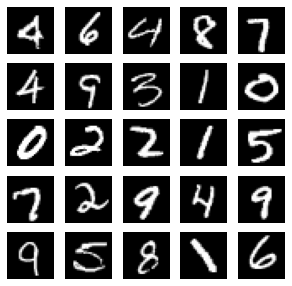

In [123]:
# Plot 25 mnist digits samples from train dataset
index = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[index]
labels = y_train[index]

# plot the 25 mnist digits
plt.figure(figsize=(5,5))

for i in range(len(index)):
    plt.subplot(5, 5, i + 1)  # nrows, ncols, index
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.close('all')

### Preprocess

In [124]:
# Scale images to the [0, 1] range
x_train_scaled = x_train.astype("float32") / 255
x_test_scaled = x_test.astype("float32") / 255

print("======BEFORE======")
print("x_train shape: \n", x_train_scaled.shape, sep = '')
print("train samples", x_train_scaled.shape[0])
print("test samples", x_test_scaled.shape[0])

# Make sure images have shape (28, 28, 1)
x_train_scaled = np.expand_dims(x_train_scaled, -1)
x_test_scaled = np.expand_dims(x_test_scaled, -1)

print("======AFTER======")
print("x_train shape: \n", x_train_scaled.shape, sep = '')
print("train samples", x_train_scaled.shape[0])
print("test samples", x_test_scaled.shape[0])

======BEFORE======
x_train shape: 
(60000, 28, 28)
train samples 60000
test samples 10000
======AFTER======
x_train shape: 
(60000, 28, 28, 1)
train samples 60000
test samples 10000


In [125]:
# MNIST Class & Input Shape
classes = list(range(10))
num_classes = 10
image_size = x_train.shape[1]
input_size = image_size * image_size

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Make Train Image for this task
- Make Train image as requested

In [126]:
def concat_h(im1, im2):
    concat = np.concatenate((im1, im2), axis=1)
    return concat

def concat_v(im1, im2):
    concat = np.concatenate((im1, im2), axis=0)
    return concat

In [127]:
def concat_imgs(original):
    # concatenate images
    concat = []

    for i in range(original.shape[0]):
        # get batch
        imgs = original[i]

        for j in range(len(imgs)):
            if j < 4: #first row
                if j == 0:
                    img1 = imgs[j]
                else:
                    img1=concat_h(img1, imgs[j])
            elif j < 8: #second row
                if j == 4:
                    img2 = imgs[j]
                else:
                    img2=concat_h(img2, imgs[j])
            elif j < 12: #third row
                if j == 8:
                    img3 = imgs[j]
                else:
                    img3=concat_h(img3, imgs[j])
            else: #fourth row
                if j == 12:
                    img4 = imgs[j]
                else:
                    img4=concat_h(img4, imgs[j])

        # concat all
        tmp_original = img1
        tmp_original = concat_v(tmp_original, img2)
        tmp_original = concat_v(tmp_original, img3)
        tmp_original = concat_v(tmp_original, img4)

        concat.append(tmp_original)

    concat = np.array(concat)
    
    return concat

In [128]:
x_test.shape

(10000, 28, 28)

In [129]:
y_test.shape

(10000, 10)

In [130]:
num_samples = 16

In [131]:
x_train_concat = rearrange(x_train, '(a b) c d -> a b c d', b=num_samples)
x_train_concat = concat_imgs(x_train_concat)
x_train_concat = np.expand_dims(x_train_concat, -1)
x_train_concat.shape

(3750, 112, 112, 1)

In [132]:
x_test_concat = rearrange(x_test, '(a b) c d -> a b c d', b=num_samples)
x_test_concat = concat_imgs(x_test_concat)
x_test_concat = np.expand_dims(x_test_concat, -1)
x_test_concat.shape

(625, 112, 112, 1)

In [133]:
y_train_concat = rearrange(y_train, '(a b) c -> a b c', b=num_samples)
train_labels = np.argmax(y_train_concat, axis = 2)
train_labels.shape

(3750, 16)

In [134]:
y_test_concat = rearrange(y_test, '(a b) c -> a b c', b=num_samples)
test_labels = np.argmax(y_test_concat, axis = 2)
test_labels.shape

(625, 16)

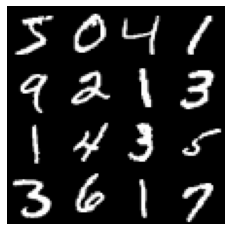

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]


In [135]:
plt.figure(figsize=(4,4))

image = np.squeeze(x_train_concat[0])
label = train_labels[0]
plt.imshow(image, cmap='gray')
plt.axis('off')
    
plt.show()
plt.close('all')

print(label)

In [136]:
input_shape = (112, 112, 1)

## Train CNN Model

In [56]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        # block1
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        # block2
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        # block3
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     
        # block4
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        # Convolutional layers transfered from fully-connected layers
        layers.Conv2D(4096, kernel_size=(4, 4), activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Conv2D(2048, kernel_size=(1, 1), activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        # classify
        layers.Conv2D(num_classes, kernel_size=(1, 1), activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 128)      

In [57]:
# model compile
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### TRAIN

In [58]:
print(x_train_concat.shape)
print(y_train_concat.shape)

(3750, 112, 112, 1)
(3750, 16, 10)


In [59]:
y_train_concat.shape

(3750, 16, 10)

In [60]:
test = y_train_concat.reshape((-1, 4, 4, 10))
test.shape

(3750, 4, 4, 10)

In [61]:
# hyperparameter
batch_size = 128
epochs = 50

In [62]:
# train
history = model.fit(x_train_concat, y_train_concat.reshape((-1, 4, 4, 10)), batch_size=batch_size, epochs=epochs)

Epoch 1/50
30/30 [==============================] - 10s 310ms/step - loss: 2.9097 - accuracy: 0.1692
Epoch 2/50
30/30 [==============================] - 9s 311ms/step - loss: 1.9813 - accuracy: 0.2833
Epoch 3/50
30/30 [==============================] - 9s 311ms/step - loss: 1.4616 - accuracy: 0.4268
Epoch 4/50
30/30 [==============================] - 9s 312ms/step - loss: 0.9251 - accuracy: 0.6388
Epoch 5/50
30/30 [==============================] - 9s 312ms/step - loss: 0.4355 - accuracy: 0.8536
Epoch 6/50
30/30 [==============================] - 9s 312ms/step - loss: 0.1582 - accuracy: 0.9523
Epoch 7/50
30/30 [==============================] - 9s 313ms/step - loss: 0.0852 - accuracy: 0.9745
Epoch 8/50
30/30 [==============================] - 9s 312ms/step - loss: 0.0589 - accuracy: 0.9819
Epoch 9/50
30/30 [==============================] - 9s 313ms/step - loss: 0.0435 - accuracy: 0.9865
Epoch 10/50
30/30 [==============================] - 9s 314ms/step - loss: 0.0311 - accuracy: 0.990

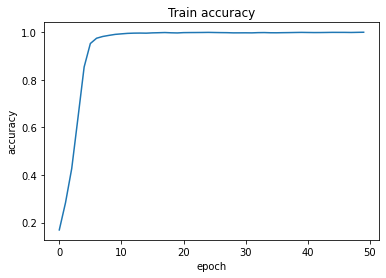

In [63]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('CNN_accuracy.png') 
plt.show()

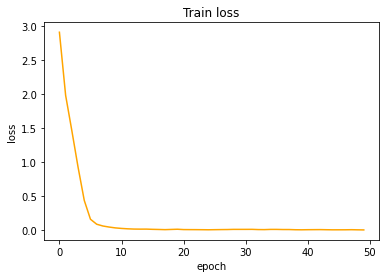

In [64]:
# summarize history for loss
plt.plot(history.history['loss'], color="orange")
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('CNN_loss.png') 
plt.show()

In [65]:
# check model
score = model.evaluate(x_test_concat, y_test_concat.reshape((-1, 4, 4, 10)), verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

20/20 [==============================] - 1s 30ms/step - loss: 0.0534 - accuracy: 0.9895
Test loss: 0.05336606502532959
Test accuracy: 0.9894999861717224


In [66]:
model.save('CNN_FCN.h5')

In [67]:
x_coords = [0, 28, 56, 84]
y_coords = [0, 28, 56, 84]
coords = []

for y in y_coords:
    for x in x_coords:
        coords.append((y,x))

print(coords)

[(0, 0), (0, 28), (0, 56), (0, 84), (28, 0), (28, 28), (28, 56), (28, 84), (56, 0), (56, 28), (56, 56), (56, 84), (84, 0), (84, 28), (84, 56), (84, 84)]


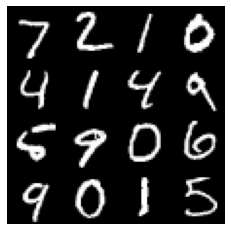

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]


In [68]:
plt.figure(figsize=(4,4))

image = np.squeeze(x_test_concat[0])
label = test_labels[0]
plt.imshow(image, cmap='gray')
plt.axis('off')
    
plt.show()
plt.close('all')

print(label)

In [88]:
x_test_concat[0].shape

(112, 112, 1)

In [101]:
test_labels[0]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5])

In [112]:
test = np.expand_dims(x_test_concat[0], 0)
test.shape

(1, 112, 112, 1)

In [113]:
np.squeeze(model.predict(test)).shape

(4, 4, 10)

In [115]:
num_samples = 16

# test = y_train_concat.reshape((-1, 4, 4, 10))

reshape_test = rearrange(model.predict(test), 'a b c d -> (a b c) d')
reshape_test.shape

(16, 10)

In [117]:
np.argmax(reshape_test, axis =1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5])

In [91]:
def visualization(image, viz):
    rect = []
    for y,x in viz:
        rect.append((x,y,28,28))
    
    plt.figure(figsize=(4,4))

    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    ax = plt.gca()
    
    for (x, y, w, h) in rect:
        ax.add_patch(
            patches.Rectangle(
                (x, y), w, h,
                edgecolor='red',
                facecolor='none',
                linewidth=2,
                fill=True))

    plt.show()
    plt.close('all')

In [143]:
def digit_detection(image, true_lbl, target, coords = coords):
    prediction = []
    viz = []
    
    # predict
    pred_img = np.expand_dims(image, 0)
    pred = rearrange(model.predict(pred_img), 'a b c d -> (a b c) d')
    pred_lbl = np.argmax(pred, axis =1)

    print(f'TRUE :            {true_lbl}')
    print(f'PREDICTED :       {pred_lbl}\n')

    for i, p in enumerate(pred_lbl):
        if p == target:
            viz.append(coords[i])
    
    print(f'TARGET :          {target}\n')

    viz_img = np.squeeze(image)

    visualization(viz_img, viz)     


TRUE :            [9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]
PREDICTED :       [9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]

TARGET :          7



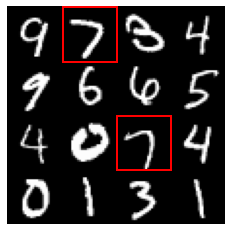

In [144]:
img_idx  = 1
target = 7

digit_detection(x_test_concat[img_idx], test_labels[img_idx], target)

TRUE :            [9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]
PREDICTED :       [9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]

TARGET :          1



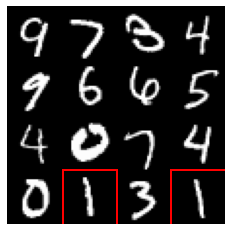

In [145]:
img_idx  = 1
target = 1

digit_detection(x_test_concat[img_idx], test_labels[img_idx], target)

TRUE :            [3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2]
PREDICTED :       [3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2]

TARGET :          1



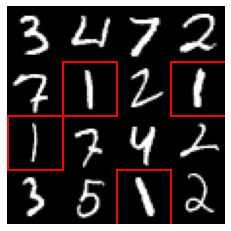

In [146]:
img_idx  = 2
target = 1

digit_detection(x_test_concat[img_idx], test_labels[img_idx], target)

TRUE :            [3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2]
PREDICTED :       [3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2]

TARGET :          4



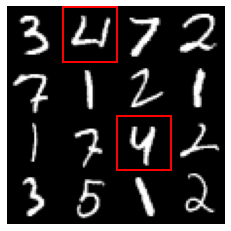

In [147]:
img_idx  = 2
target = 4

digit_detection(x_test_concat[img_idx], test_labels[img_idx], target)